# Assignment 3

As discussed in class, New York City's stop and frisk policy was found to be unconstitutional by a federal judge in 2013 (Floyd v. City of New York) on the grounds that it violated the Fourth Amendment (which prohibits unreasonable searches) and Fourteenth Amendment (which prohibits racial discrimination). Here, we use mapping techniques, applied to [stop and frisk data](https://5harad.com/data/sqf.RData), to examine some of the evidence which led to the Fourteenth Amendment ruling. 

And we will also use [census data](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.2012.html ) (2012 ACS for NYC) for this assignment. For this census data, you may also want to only [load some layers](https://geopandas.org/docs/user_guide/io.html) of this file. And you can also use ["listlayers" function in fiona package to check all layers](https://fiona.readthedocs.io/en/latest/manual.html#reading-multilayer-data) in 'datasets/ACS_2012_5YR_TRACT_36_NEW_YORK.gdb'

Some special packages you may need in this assignments: geopandas, shapely, or maybe shapefile

## Part 1
#### Filter all stop and frisk data with *suspected.crime* as "cpw" in NYC from 2012 to 2013, and randomly select 10,000 data points. Then, use the latitude and longitude values in the stop and frisk dataset (remember to create a geometry column for geopandas to use) and the shapefile of NYC, plot their locations on NYC map. Color each stop by the race of the pedestrian stopped. Write a couple sentences about what you see. (25 points)

Please note that 
* you only need to select five NYC counties in NY shapefile, and the FIPS codes of them are 005 (Bronx County), 047 (Kings County), 061 (New York County), 081 (Queens County), and 085 (Richmond County). 
* treat both "black hispanic" and "white hispanic" as "hispanic", and we only consider four races (white, black, Hispanic and Asian) in this assignment
* you may want to set latitude and longtitude range in your plot if necessary. 
* make your map and dots partially transparent, so it will be easier for you to observe some patterns
* set column value as 'COUNTYFP' during the plotting of NYC map, so it will give the whole county just one color
* make your figure clear enough to interpret

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
# Load the stop and frisk data from the specified CSV file
sqf_d = pd.read_csv('a3_data/sqf.csv')

# Display the first few rows of the dataset to understand its structure
# This shows the first five rows of the DataFrame for inspection
sqf_d.head()

/tmp/ipykernel_3227/8522198.py:2: DtypeWarning: Columns (7,18,19,20,66,77) have mixed types. Specify dtype option on import or set low_memory=False.
  sqf_d = pd.read_csv('a3_data/sqf.csv')


,year,date,time,xcoord,ycoord,serial,radio.run,inside.outside,location.housing,observation.period,...,suspect.height,suspect.weight,suspect.hair,suspect.eye,suspect.build,found.gun,found.weapon,id,lat,lon
0,2006,NaN,NaN,1006611.0,233503.0,NaN,False,NaN,neither,NaN,...,5.583333,160.0,black,brown,medium,False,False,2,40.807559,-73.919226
1,2006,2006-01-01,14:10,981738.0,198272.0,1.0,False,True,transit,15.0,...,6.083333,155.0,black,brown,thin,False,False,3,40.710887,-74.009061
2,2006,2006-01-01,08:50,981349.0,198508.0,2.0,False,True,transit,5.0,...,5.666667,180.0,brown,brown,medium,False,False,4,40.711535,-74.010464
3,2006,2006-01-02,17:00,982103.0,198029.0,3.0,False,True,transit,2.0,...,5.583333,170.0,black,black,medium,False,False,5,40.710220,-74.007744
4,2006,2006-01-01,20:10,983359.0,203119.0,4.0,True,True,neither,5.0,...,5.666667,200.0,brown,brown,medium,False,False,6,40.724191,-74.003215


In [3]:
# Display the names of all columns in the stop and frisk DataFrame
# This retrieves the column names for inspection
sqf_d.columns

# Display the names of all columns in the stop and frisk DataFrame
column_names = sqf_d.columns  # This retrieves the column names for inspection
print(column_names)  # Print the column names to understand the available data

Index(['year', 'date', 'time', 'xcoord', 'ycoord', 'serial', 'radio.run',
       'inside.outside', 'location.housing', 'observation.period',
       'suspected.crime', 'stop.length', 'identification', 'reason.explained',
       'others.stopped', 'arrested', 'arrested.reason', 'summons.issued',
       'officer.uniform', 'officer.verbal', 'officer.shield', 'frisked',
       'searched', 'extra.reports', 'force.hands', 'force.wall',
       'force.ground', 'force.drawn', 'force.pointed', 'force.baton',
       'force.handcuffs', 'force.pepper', 'force.other', 'stopped.bc.object',
       'stopped.bc.desc', 'stopped.bc.casing', 'stopped.bc.lookout',
       'stopped.bc.clothing', 'stopped.bc.drugs', 'stopped.bc.furtive',
       'stopped.bc.violent', 'stopped.bc.bulge', 'stopped.bc.other',
       'frisked.bc.suspected.crime', 'frisked.bc.weapons', 'frisked.bc.attire',
       'frisked.bc.actual.crime', 'frisked.bc.noncompliance',
       'frisked.bc.threats', 'frisked.bc.prior', 'frisked.bc.furtive

In [4]:
# Load the stop and frisk data. Only use appropriate data for efficiency
sqf_d = pd.read_csv('a3_data/sqf.csv', usecols=['year', 'suspected.crime', 'lat', 'lon', 'suspect.race'])
print(sqf_d.head())

   year suspected.crime    suspect.race        lat        lon
0  2006             cpw           black  40.807559 -73.919226
1  2006    sexual abuse  white hispanic  40.710887 -74.009061
2  2006   grand larceny           black  40.711535 -74.010464
3  2006             cpw           black  40.710220 -74.007744
4  2006        burglary           white  40.724191 -74.003215


In [5]:
# Filter the dataset for "cpw" (criminal possession of a weapon) incidents in 2012 and 2013
cpw_filtered = sqf_d[(sqf_d['year'].isin([2012, 2013])) & (sqf_d['suspected.crime'] == 'cpw')]

# Randomly sample 10,000 data points from the filtered dataset
cpw_sample = cpw_filtered.sample(n=10000, random_state=42)

# Display the sampled data to confirm the selection
print(cpw_sample) 

         year suspected.crime    suspect.race        lat        lon
4055877  2013             cpw  black hispanic  40.818755 -73.850101
3918750  2013             cpw           black  40.812061 -73.915684
3749920  2012             cpw           black  40.812439 -73.952542
4002240  2013             cpw  white hispanic  40.804420 -73.955369
3738117  2012             cpw           black  40.659338 -73.909065
...       ...             ...             ...        ...        ...
3710975  2012             cpw  white hispanic  40.832509 -73.886438
3824812  2012             cpw           black  40.818331 -73.903504
3597857  2012             cpw  white hispanic  40.807559 -73.919226
3597434  2012             cpw  white hispanic  40.815418 -73.905047
4043733  2013             cpw           black  40.718417 -73.808607

[10000 rows x 5 columns]


In [6]:
# Create a geometry column using the longitude and latitude from the sampled data
geometry = [Point(xy) for xy in zip(cpw_sample['lon'], cpw_sample['lat'])]

# Create a GeoDataFrame using the sampled data and the new geometry column
gdf = gpd.GeoDataFrame(cpw_sample, geometry=geometry)

# Display the column names of the GeoDataFrame to confirm the structure
print(gdf.columns)  # This shows the names of all columns, including the geometry column

# Display the unique values in the 'suspect.race' column to check race categories
# This shows the distinct races present in the sampled data
print(gdf['suspect.race'].unique())  

Index(['year', 'suspected.crime', 'suspect.race', 'lat', 'lon', 'geometry'], dtype='object')
['black hispanic' 'black' 'white hispanic' 'white' 'native american' nan
 'asian' 'other']


In [7]:
# Standardize race categories: treat both "black hispanic" and "white hispanic" as "hispanic"
gdf['suspect.race'] = gdf['suspect.race'].replace({'black hispanic': 'hispanic', 'white hispanic': 'hispanic'})

# Filter the GeoDataFrame to only include specified race categories
gdf = gdf[gdf['suspect.race'].isin(['white', 'black', 'hispanic', 'asian'])]

# Display the unique race values to confirm the standardization and filtering
print(gdf['suspect.race'].unique())  # This shows the distinct races present after filtering

['hispanic' 'black' 'white' 'asian']


In [8]:
import fiona

In [9]:
# Load NYC census data
gdb_path = 'a3_data/ACS_2012_5YR_TRACT_36_NEW_YORK.gdb'

print(fiona.listlayers(gdb_path))

['ACS_2012_5YR_TRACT_36_NEW_YORK', 'X00_COUNTS', 'X01_AGE_AND_SEX', 'X02_RACE', 'X03_HISPANIC_OR_LATINO_ORIGIN', 'X04_ANCESTRY', 'X05_FOREIGN_BORN_CITIZENSHIP', 'X06_PLACE_OF_BIRTH', 'X07_MIGRATION', 'X08_COMMUTING', 'X09_CHILDREN_HOUSEHOLD_RELATIONSHIP', 'X10_GRANDPARENTS_GRANDCHILDREN', 'X11_HOUSEHOLD_FAMILY_SUBFAMILIES', 'X12_MARITAL_STATUS_AND_HISTORY', 'X13_FERTILITY', 'X14_SCHOOL_ENROLLMENT', 'X15_EDUCATIONAL_ATTAINMENT', 'X16_LANGUAGE_SPOKEN_AT_HOME', 'X17_POVERTY', 'X18_DISABILITY', 'X19_INCOME', 'X20_EARNINGS', 'X21_VETERAN_STATUS', 'X22_FOOD_STAMPS', 'X23_EMPLOYMENT_STATUS', 'X24_INDUSTRY_OCCUPATION', 'X25_HOUSING_CHARACTERISTICS', 'X26_GROUP_QUARTERS', 'X27_HEALTH_INSURANCE', 'TRACT_METADATA_2012']


In [10]:
# Load the NYC census data from the specified geodatabase layer
nyc_census = gpd.read_file(gdb_path, layer='ACS_2012_5YR_TRACT_36_NEW_YORK')

# Display the unique column names in the NYC census DataFrame to understand its structure
print(nyc_census.columns.unique())  # This shows all unique column names for inspection

# Filter the census data for the specified counties based on their FIPS codes
nyc_counties = nyc_census[nyc_census['COUNTYFP'].isin(['005', '047', '061', '081', '085'])]

# Display the unique FIPS codes in the filtered counties to confirm the filtering was successful
print(nyc_counties['COUNTYFP'].unique())  # This shows the distinct FIPS codes present after filtering

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Length',
       'Shape_Area', 'GEOID_Data', 'geometry'],
      dtype='object')
['061' '085' '005' '047' '081']


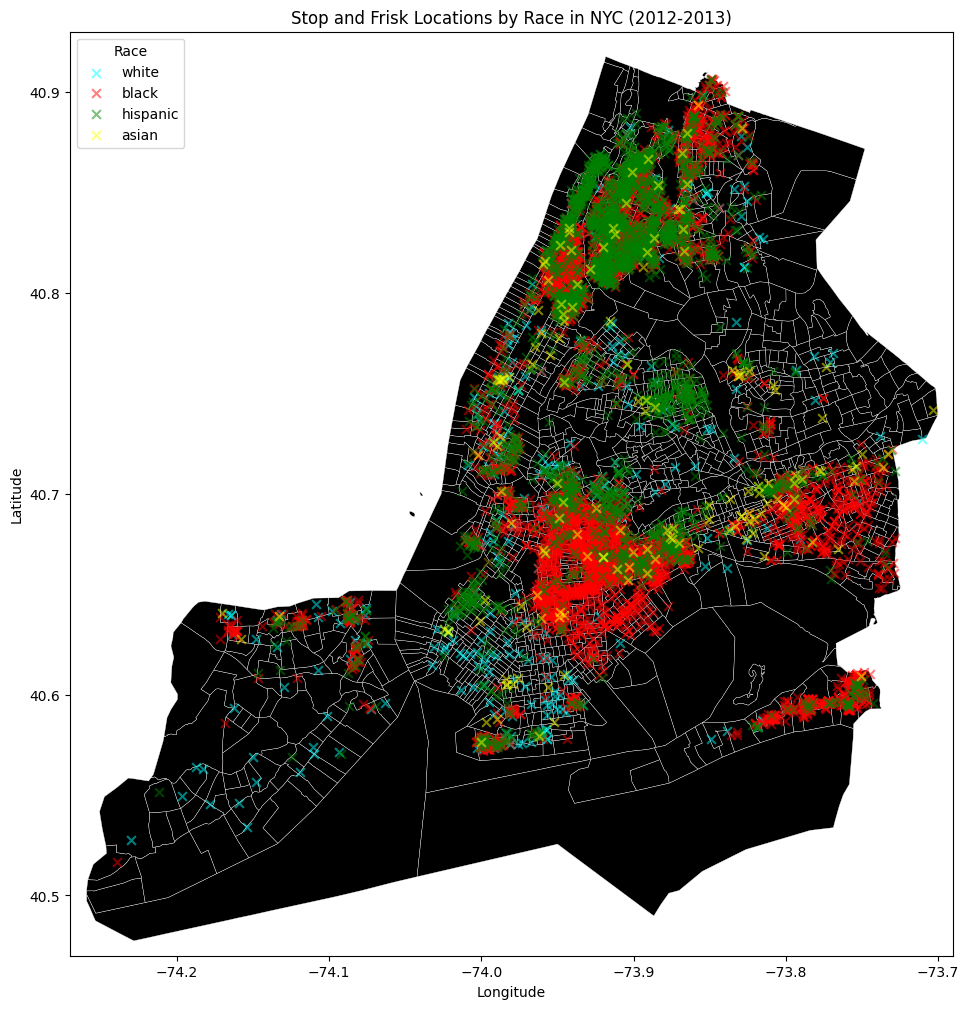

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
nyc_counties.plot(ax=ax, color='black', edgecolor='white', linewidth=0.25, alpha=1.0)

# Define color and marker maps for different races
color_map = {
    'white': 'cyan', 
    'black': 'red', 
    'hispanic': 'green', 
    'asian': 'yellow'
}
marker_map = {
    'white': 'x', 
    'black': 'x', 
    'hispanic': 'x', 
    'asian': 'x'
}

for race, color in color_map.items():
    race_data = gdf[gdf['suspect.race'] == race]  # Filter data for the specific race
    ax.scatter(
        race_data.geometry.x,  # Longitude values
        race_data.geometry.y,  # Latitude values
        color=color, 
        marker=marker_map[race], 
        alpha=0.5,  # Set transparency for better visibility
        s=40,  # Marker size
        label=race  # Label for the legend
    )

ax.set_xlim([-74.27, -73.69])  # Longitude range for NYC
ax.set_ylim([40.47, 40.93])     # Latitude range for NYC

plt.title('Stop and Frisk Locations by Race in NYC (2012-2013)', color='black')
plt.xlabel('Longitude', color='black')
plt.ylabel('Latitude', color='black')

ax.legend(title='Race', loc='upper left')
ax.tick_params(axis='both', colors='black')
plt.show()

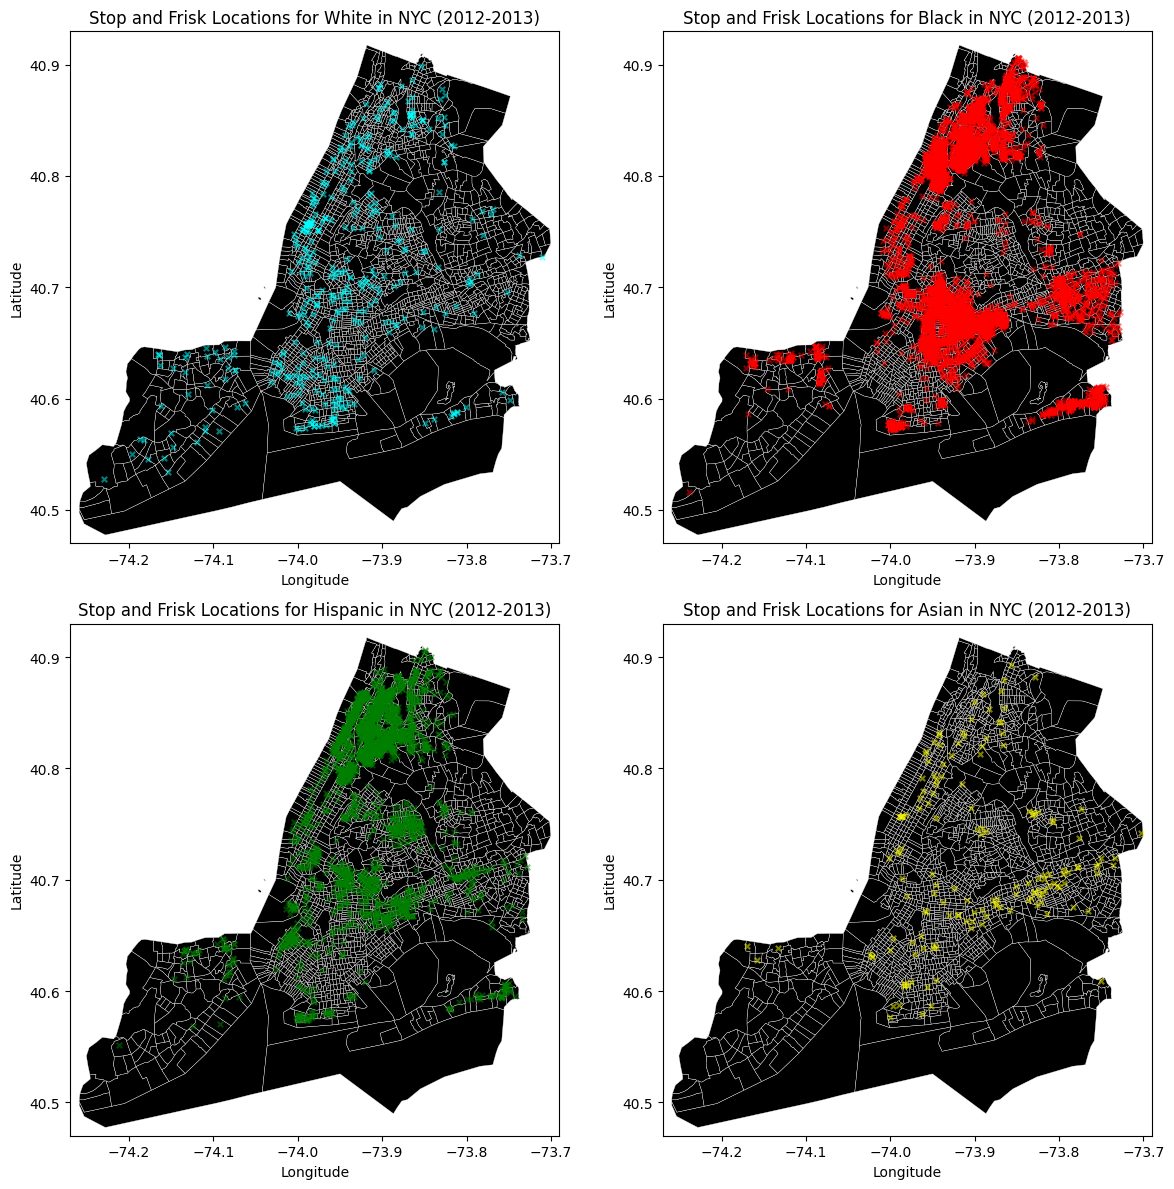

In [12]:
# Define race categories, corresponding colors, and titles for the subplots
races = ['white', 'black', 'hispanic', 'asian']
colors = ['cyan', 'red', 'green', 'yellow']
titles = ['White', 'Black', 'Hispanic', 'Asian']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

# Loop through each race and plot the data
for i, race in enumerate(races):
    ax = axs[i]
    
    # Plot the NYC counties for each subplot
    nyc_counties.plot(ax=ax, color='black', edgecolor='white', linewidth=0.25, alpha=1.0)
    
    # Filter data for the specific race
    race_data = gdf[gdf['suspect.race'] == race]
    
    ax.scatter(
        race_data.geometry.x, 
        race_data.geometry.y, 
        color=colors[i], 
        marker='x', 
        alpha=0.5, 
        s=15
    )
    
    # Set limits for the axes
    ax.set_xlim([-74.27, -73.69])  # Longitude range for NYC
    ax.set_ylim([40.47, 40.93])     # Latitude range for NYC
    
    ax.set_title(f'Stop and Frisk Locations for {titles[i]} in NYC (2012-2013)', color='black')
    ax.set_xlabel('Longitude', color='black')
    ax.set_ylabel('Latitude', color='black')
    ax.tick_params(axis='both', colors='black')

plt.tight_layout()
plt.show()

In [13]:
# Ensure the 'suspect.race' column exists
if 'suspect.race' not in gdf.columns:
    raise ValueError("The 'gdf' DataFrame must contain a 'suspect.race' column.")

# Count the number of stops for each race
race_counts = gdf['suspect.race'].value_counts()

# Calculate the total number of stops
total_stops = race_counts.sum()

# Create a DataFrame for the summary
summary_df = pd.DataFrame({
    'Race': race_counts.index,
    'Count of Stops': race_counts.values,
    'Percentage of Total': (race_counts.values / total_stops * 100).round(2)
})

# Define notable areas
notable_areas = {
    'white': ['Area 1', 'Area 2'], 
    'black': ['Area 3', 'Area 4'], 
    'hispanic': ['Area 5', 'Area 6'], 
    'asian': ['Area 7', 'Area 8']
}

# Add notable areas to the summary DataFrame
summary_df['Notable Areas'] = summary_df['Race'].map(notable_areas)

# Print a header for the summary table
print("Summary of Stop and Frisk Data by Race (2012-2013)")
print("=" * 50)

# Print the summary DataFrame
print(summary_df.to_string(index=False))

Summary of Stop and Frisk Data by Race (2012-2013)
    Race  Count of Stops  Percentage of Total    Notable Areas
   black            6225                63.76 [Area 3, Area 4]
hispanic            2920                29.91 [Area 5, Area 6]
   white             453                 4.64 [Area 1, Area 2]
   asian             165                 1.69 [Area 7, Area 8]


### **Interpretation of the Data**

**1. Dominance of Black Stops:** <br>
Count: The majority of stops (6,225) involved Black individuals, making up 63.76% of total stops. This high percentage raises concerns about potential racial profiling and the disproportionate impact of stop and frisk practices on Black communities.

**2. Significant Hispanic Representation:** <br>
Count: Hispanic individuals accounted for 2,920 stops (29.91%). While not as high as for Black individuals, this still represents a substantial portion of stops, indicating potential biases against Hispanic communities as well.
Low Numbers for White and Asian Individuals:

**3. Count:** <br>
White stops (453) and Asian stops (165) are significantly lower, comprising only 4.64% and 1.69%, respectively. This disparity suggests that the stop and frisk policy disproportionately targets Black and Hispanic individuals compared to White and Asian individuals.

The data reveals that Black and Hispanic individuals are the most frequently stopped and frisked, with a notably higher concentration of stops in Bronx County (005) and Kings County (047). In contrast, Asian and White individuals are stopped far less often, with these events being more evenly spread across different districts. Notably, Richmond County has the fewest stops, even when considering its geographical size. On the other hand, the Bronx has the highest concentration of stops relative to its area.

## Part 2
#### Use the Census data shapefile, make four maps: 

1) plotting the population proportion of each block group which is white; 
2) plotting the population proportion of each block group which is black; 
3) plotting the population proportion of each block group which is Hispanic.
4) plotting the population proportion of each block group which is Asian.

#### Look at the maps from part 1 and part 2 side by side and write a few sentences summarizing your conclusions. (30 points)

*Please note:* 
* "In each geodatabase is a metadata file with a short name and a full description of each cell. The attribute table for each geodatabase contains the short names for each data element." (https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/tiger-line-demo-record-layouts.html) 
* You may want to use the density of color to show the difference of population proportion
* make your figures clear enough to interpret

In [14]:
# Define the path to the Census geodatabase
gdb_path = 'a3_data/ACS_2012_5YR_TRACT_36_NEW_YORK.gdb'

# Load the NYC census data for block groups
nyc_census = gpd.read_file(gdb_path, layer='ACS_2012_5YR_TRACT_36_NEW_YORK')

# Load race data from the Census geodatabase
race_data = gpd.read_file(gdb_path, layer='X02_RACE')

# Load Hispanic or Latino origin data from the Census geodatabase
hispanic_data = gpd.read_file(gdb_path, layer='X03_HISPANIC_OR_LATINO_ORIGIN')

# print(type(race_data))
# print(race_data.columns)
# print(race_data['GEOID'])
# print(type(nyc_census))
# print(nyc_census)
# nyc_census['GEOID_Data']

In [15]:
# Merge the NYC census data with race data using a left join
# The left join keeps all records from the nyc_census and adds matching records from race_data
nyc_census_full = nyc_census.merge(race_data, how='left', left_on='GEOID_Data', right_on='GEOID')

# Merge the updated census data with Hispanic origin data using a left join
# This adds the Hispanic data while retaining all records from the previous merge
nyc_census_full = nyc_census_full.merge(hispanic_data, how='left', left_on='GEOID_Data', right_on='GEOID')

# Convert the merged DataFrame to a GeoDataFrame
# This ensures that the geometry column is properly associated with the merged data
nyc_census_full = gpd.GeoDataFrame(nyc_census_full, geometry=nyc_census.geometry)

In [16]:
# 'X02_RACE'
# B02001e1	RACE: Total: Total population -- (Estimate)
# B02001e2	RACE: Total: White alone: Total population -- (Estimate)
# B02001e3	RACE: Total: Black or African American alone: Total population -- (Estimate)
# B02001e5	RACE: Total: Asian alone: Total population -- (Estimate)

# Note: There is no Hispanic population data in 'X02_RACE', 
# so we need to use 'X03_HISPANIC_OR_LATINO_ORIGIN'

# 'X03_HISPANIC_OR_LATINO_ORIGIN'
# B03001e3: HISPANIC OR LATINO ORIGIN BY SPECIFIC ORIGIN: Hispanic or Latino: Total population -- (Estimate)

# Making sure that X02 and X03 value is matching

# white population data for X02 - X03 comparison
# Assuming the below plot have to be the same, but not the true in this case..? Not a big difference though.
# print(nyc_census_full['B02001e2'])
# print(nyc_census_full['B03002e3'])

# Total population is same
# print(nyc_census_full['B02001e1'])
# print(nyc_census_full['B03001e1'])

# black population data for X02 - X03 comparison
# Assuming the below plot have to be the same, but not the true in this case..? Not a big difference though.
# print(nyc_census_full['B02001e3'])
# print(nyc_census_full['B03002e4'])


#### IMPORTANT #### 
# Conclued to use 'X03_HISPANIC_OR_LATINO_ORIGIN' to make all the data is inside X03


# Define column names for total and racial populations based on X03
total_pop = 'B03001e1'     # Total population
white_pop = 'B03002e3'     # White population
black_pop = 'B03002e4'     # Black population
asian_pop = 'B03002e6'     # Asian population
hispanic_pop = 'B03001e3'  # Hispanic population

# Calculate population proportions
nyc_census_full['white_proportion'] = nyc_census_full[white_pop] / nyc_census_full[total_pop]
nyc_census_full['black_proportion'] = nyc_census_full[black_pop] / nyc_census_full[total_pop]
nyc_census_full['asian_proportion'] = nyc_census_full[asian_pop] / nyc_census_full[total_pop]
nyc_census_full['hispanic_proportion'] = nyc_census_full[hispanic_pop] / nyc_census_full[total_pop]

In [17]:
# Filter for NYC counties
nyc_counties_proportion = nyc_census_full[nyc_census_full['COUNTYFP'].isin(['005', '047', '061', '081', '085'])]

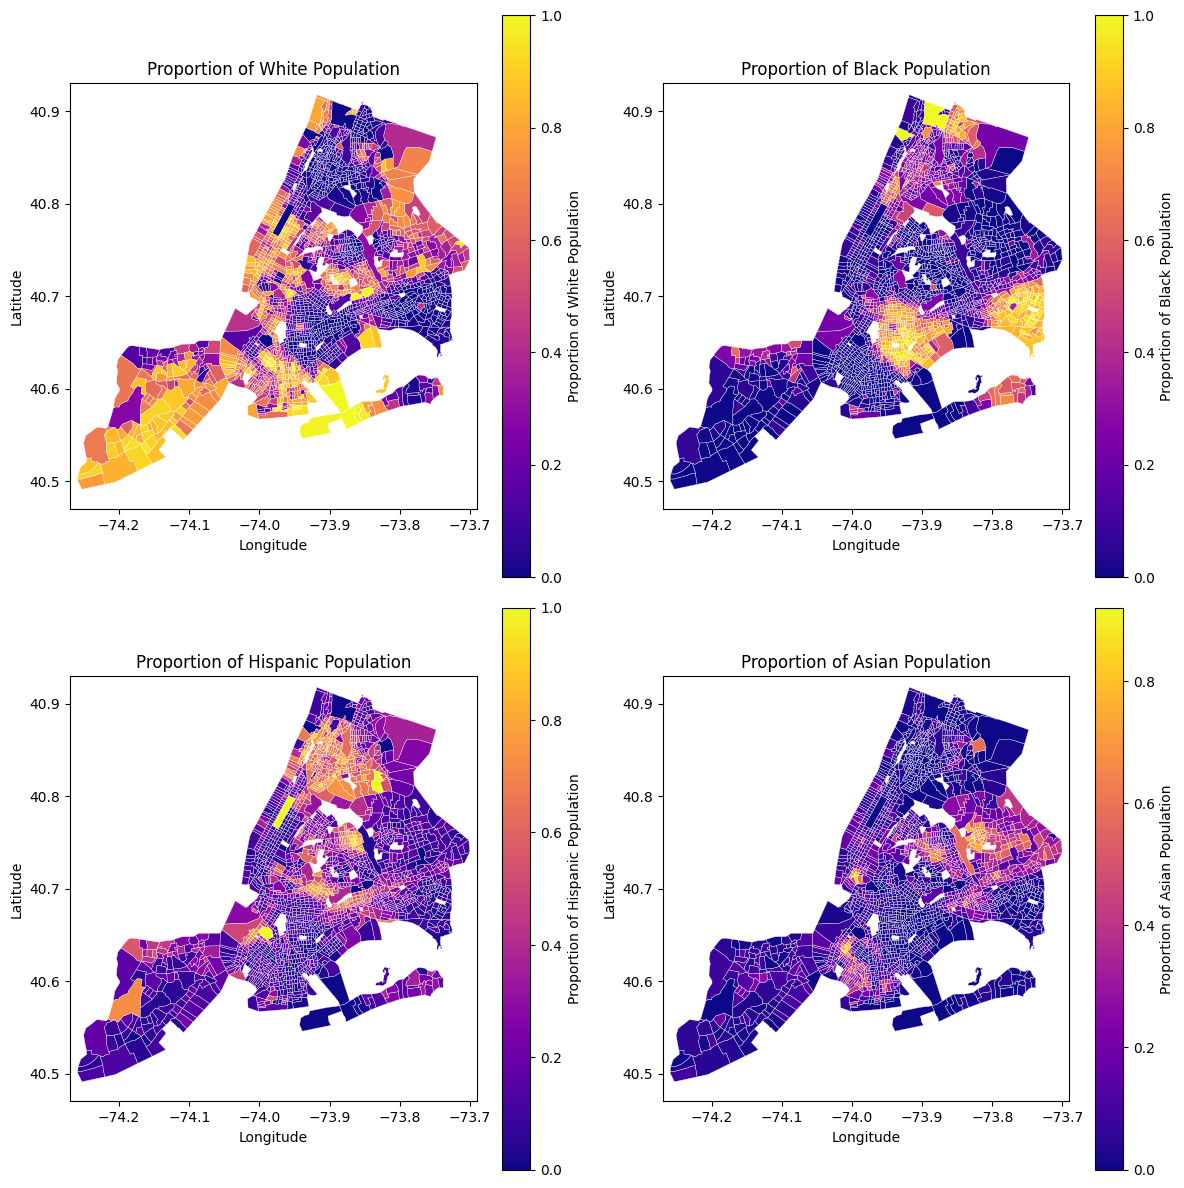

In [18]:
# Create maps without stop and frisk overlay
races = ['white', 'black', 'hispanic', 'asian']
titles = ['White', 'Black', 'Hispanic', 'Asian']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, race in enumerate(races):
    ax = axs[i]
    
    # Plot the population proportion map
    nyc_counties_proportion.plot(column=f'{race}_proportion', ax=ax, legend=True,
                                 cmap='plasma', edgecolor='white', linewidth=0.25,
                                 legend_kwds={'label': f"Proportion of {titles[i]} Population"})
    
    # Set limits for the axes
    ax.set_xlim([-74.27, -73.69])  # Longitude range for NYC
    ax.set_ylim([40.47, 40.93])    # Latitude range for NYC
    
    ax.set_title(f'Proportion of {titles[i]} Population')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.tick_params(axis='both')

plt.tight_layout()
plt.show()

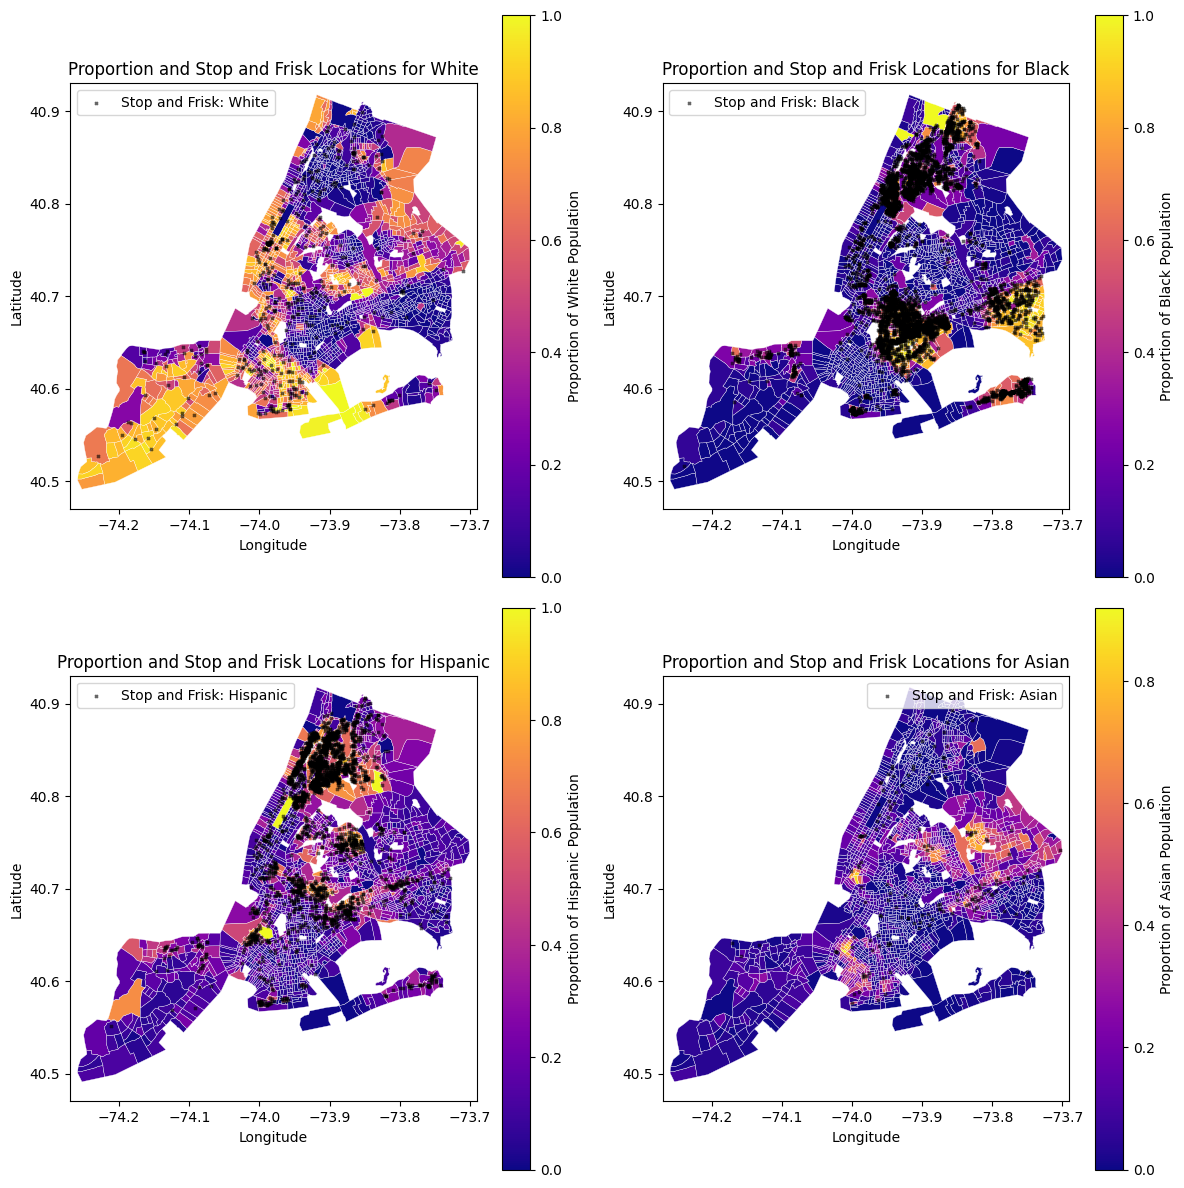

In [19]:
# Define race categories for overlaying stop and frisk data
races = ['white', 'black', 'hispanic', 'asian']
color = ['black']
titles = ['White', 'Black', 'Hispanic', 'Asian']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

# Iterate through each race to create subplots
for i, race in enumerate(races):
    ax = axs[i]
    
    nyc_counties_proportion.plot(column=f'{race}_proportion', ax=ax, legend=True,
                      cmap='plasma', edgecolor='white', linewidth=0.25,
                      legend_kwds={'label': f"Proportion of {titles[i]} Population"})
    
    race_data = gdf[gdf['suspect.race'] == race]  
    
    ax.scatter(
        race_data.geometry.x, 
        race_data.geometry.y, 
        color=color, 
        marker='x', 
        alpha=0.60, 
        s=4,
        label=f'Stop and Frisk: {titles[i]}'
    )
    
    # Set limits for the axes
    ax.set_xlim([-74.27, -73.69])  # Longitude range for NYC
    ax.set_ylim([40.47, 40.93])     # Latitude range for NYC
    
    ax.set_title(f'Proportion and Stop and Frisk Locations for {titles[i]}', color='black')
    ax.set_xlabel('Longitude', color='black')
    ax.set_ylabel('Latitude', color='black')
    ax.tick_params(axis='both', colors='black')
    ax.legend()

plt.tight_layout()
plt.show()

### **Summary of conclusions**

When examining the additional plot that overlays stop-and-frisk data with population density maps, a clear pattern emerges. In areas with higher proportions of White residents, the number of stops and frisks is almost negligible. For Asian individuals, the data shows very few stops and frisks, making it difficult to draw any definitive conclusions about potential correlations. However, for Black and Hispanic populations, there is a noticeable trend: areas with higher concentrations of Black and Hispanic residents experience significantly more stops and frisks.

While the sample size of 10,000 may introduce some bias, the use of population fractions helps mitigate this by making the data relative across groups. This disparity in stop-and-frisk rates strongly suggests that the NYPD is more likely to target individuals based on ethnicity, with Black and Hispanic individuals being disproportionately affected.

## Part 3
#### Use [NYPD's precinct and population data](https://johnkeefe.net/nyc-police-precinct-and-census-data) (*nyc_2010pop_2020precincts* and *geo_export*) and map each stop (from 2012 to 2013) to a Census block group using a [spatial join](https://geopandas.org/gallery/spatial_joins.html) (please refer to this [document](https://www.documentcloud.org/documents/87708-pl94-171-1.html#document/p64) for the meanings of different columns in this dataset.) 
#### Make a plot where each point represents one Census block group with more than 1000 residents, the x-axis is the proportion of the block group population which is white, and the y-axis is the number of stops per capita in this block. And make a regression line to show the trend in this plot. (15 points)

Precinct data shape: (77, 145)
Precinct shapes shape: (77, 4)
Merged precinct data shape: (77, 149)


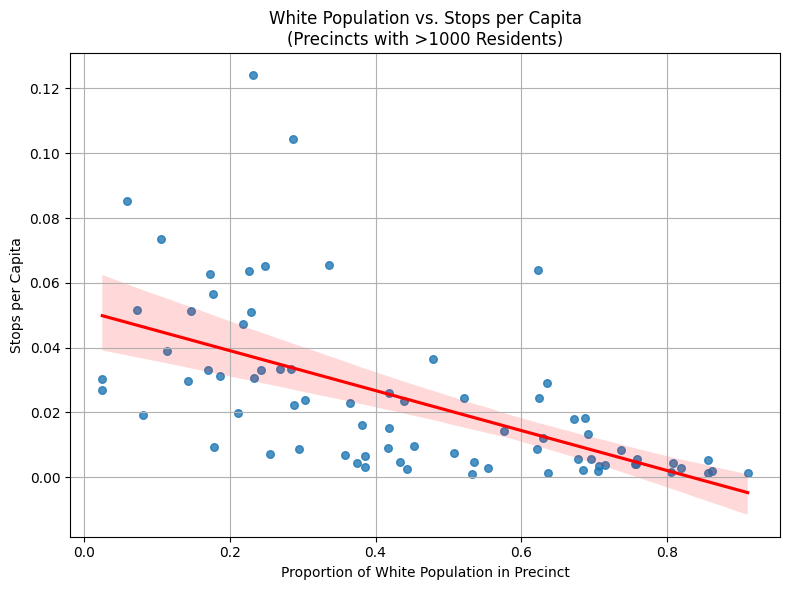

In [29]:
import seaborn as sns

# Only Filter the dataset for 2012 and 2013
year_filtered = sqf_d[(sqf_d['year'].isin([2012, 2013])) & (sqf_d['suspected.crime'] == 'cpw')]

# Create a geometry column using the longitude and latitude from the sampled data
geometry_part3 = [Point(xy) for xy in zip(year_filtered['lon'], year_filtered['lat'])]

# Create a GeoDataFrame using the sampled data and the new geometry column
gdf_part3 = gpd.GeoDataFrame(year_filtered, geometry=geometry_part3)


# Load precinct and population data
precinct_population_df = pd.read_csv('a3_data/nyc_2010pop_2020precincts.csv')
precinct_shapes_gdf = gpd.read_file('a3_data/NYC_Police_Precincts_2020/geo_export.shp')

print(f"Precinct data shape: {precinct_population_df.shape}")
print(f"Precinct shapes shape: {precinct_shapes_gdf.shape}")

# Merge population data with precinct shapes to create a GeoDataFrame
precincts_gdf = precinct_shapes_gdf.merge(precinct_population_df, left_on='precinct', right_on='precinct_2020')
precincts_gdf = gpd.GeoDataFrame(precincts_gdf)
print(f"Merged precinct data shape: {precincts_gdf.shape}")

# Data cleaning: Remove rows with missing coordinates from the stop-and-frisk data (gdf)
gdf_cleaned = gdf_part3[(gdf_part3["lon"].notna()) & (gdf_part3["lat"].notna())]

# Set the CRS (Coordinate Reference System) for both precincts and stop-and-frisk data
precincts_gdf.crs = 'EPSG:4326'
gdf_cleaned.crs = 'EPSG:4326'

# Spatial join: Link stop-and-frisk data to precincts based on location
gdf_with_precincts = gdf_cleaned.sjoin(precincts_gdf, how='inner')

# Filter precincts with more than 1,000 residents for analysis
filtered_precincts = precincts_gdf[precincts_gdf.P0010001 > 1000].precinct_2020.unique()

# Calculate the proportion of white population in each precinct
precincts_gdf['white_population_proportion'] = precincts_gdf.P0010003 / precincts_gdf.P0010001

# Function to calculate per capita stops for a specified population group in each precinct
def calculate_per_capita_stops(population_group, stops_per_capita, population_column):
    for precinct in filtered_precincts:
        # Proportion of the population group in the precinct
        population_proportion = precincts_gdf.loc[precincts_gdf.precinct_2020 == precinct, population_column].values[0]
        population_group.append(population_proportion)

        # Total stops in the precinct
        total_stops = gdf_with_precincts[gdf_with_precincts.precinct_2020 == precinct].shape[0]

        # Total population in the precinct
        total_population = precincts_gdf.loc[precincts_gdf.precinct_2020 == precinct, 'P0010001'].values[0]

        # Calculate stops per capita and store the result
        stops_per_capita.append(total_stops / total_population)

# Prepare lists for storing white population proportion and stops per capita
white_population_proportion = []
stops_per_capita_white = []

# Calculate per capita stops for the white population group
calculate_per_capita_stops(white_population_proportion, stops_per_capita_white, "white_population_proportion")

# Function to plot linear regression for the given population group
def plot_linear_regression(population_group, stops_per_capita, population_group_name):
    plt.figure(figsize=(8, 6))
    
    # Plot regression using seaborn
    sns.regplot(x=population_group, y=stops_per_capita, 
                scatter_kws={"s": 30}, 
                line_kws={"color": "red"}, 
                ci=95)

    # Set plot labels and title
    plt.xlabel(f"Proportion of {population_group_name.capitalize()} Population in Precinct")
    plt.ylabel("Stops per Capita")
    plt.title(f"{population_group_name.capitalize()} Population vs. Stops per Capita\n(Precincts with >1000 Residents)")
    
    # Adjust layout and show grid
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Plot the linear regression for the white population
plot_linear_regression(white_population_proportion, stops_per_capita_white, "white")


#### Now make the same plot, but plot a separate series for each race group (Black, Hispanic, Asian). In other words, the plot for black pedestrians should has the x-axis for Black population and y-axis for stops per capita. Summarize the conclusions from these plots. (20 points)

   black_prop  asian_prop  hispanic_prop
0    0.032424    0.158506       0.070127
1    0.052960    0.623859       0.112426
2    0.021149    0.080722       0.060762
3    0.715379    0.012730       0.093032
4    0.046336    0.265904       0.454527


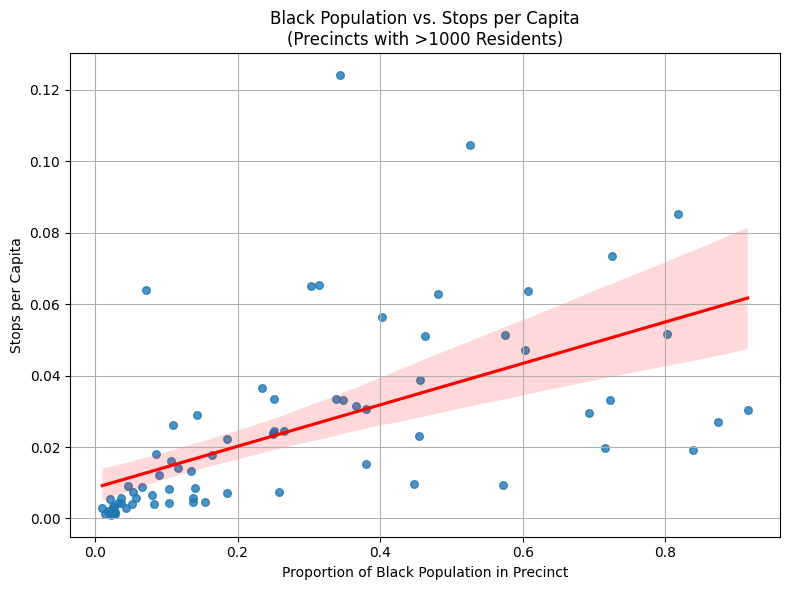

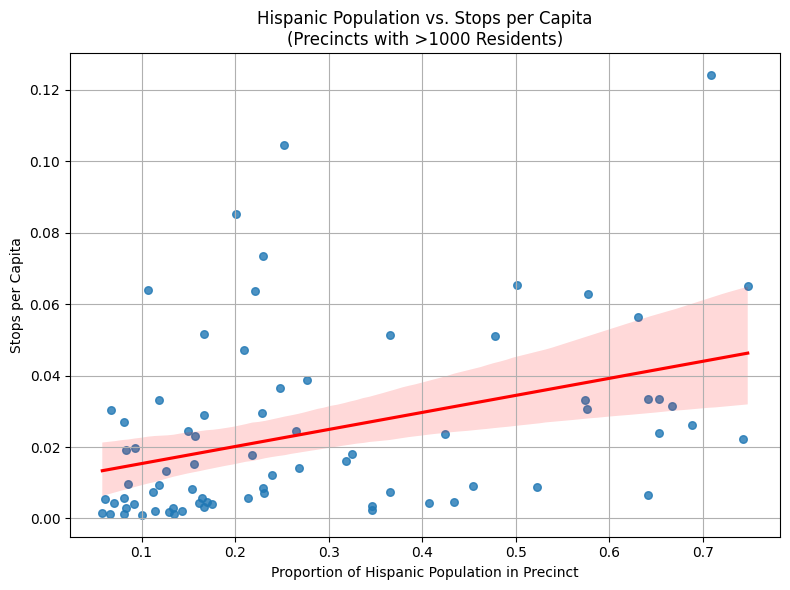

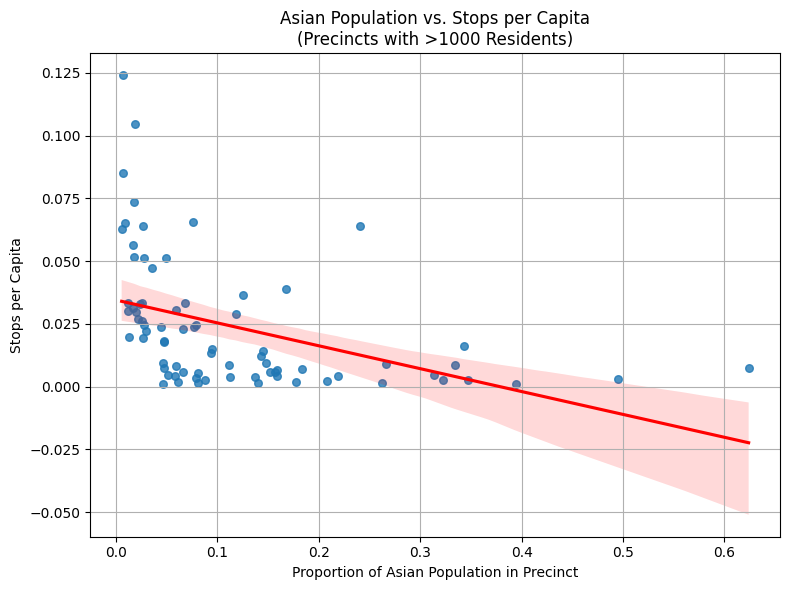

In [30]:
# Proportion of prcinct population for other etnicities
precincts_gdf['black_prop'] = precincts_gdf.P0010004 / precincts_gdf.P0010001
precincts_gdf['asian_prop'] = precincts_gdf.P0010006 / precincts_gdf.P0010001
precincts_gdf['hispanic_prop'] = precincts_gdf.P0020002 / precincts_gdf.P0010001
print(precincts_gdf[['black_prop', 'asian_prop', 'hispanic_prop']].head())

# Set for calculation of stops per capita for other
black_population_proportion = []
stops_per_capita_black = []

hispanic_population_proportion = []
stops_per_capita_hispanic = []

asian_population_proportion = []
stops_per_capita_asian = []

# Black
calculate_per_capita_stops(black_population_proportion, stops_per_capita_black, "black_prop")
plot_linear_regression(black_population_proportion, stops_per_capita_black, "black")

# Hispanic
calculate_per_capita_stops(hispanic_population_proportion, stops_per_capita_hispanic, "hispanic_prop")
plot_linear_regression(hispanic_population_proportion, stops_per_capita_hispanic, "Hispanic")

# Asian
calculate_per_capita_stops(asian_population_proportion, stops_per_capita_asian, "asian_prop")
plot_linear_regression(asian_population_proportion, stops_per_capita_asian, "Asian")

### **Summary of conclusions**

The analysis of stop-and-frisk rates across racial groups reveals clear disparities. Precincts with a higher proportion of White and Asian populations correlate with lower stop-and-frisk rates per capita, while precincts with a higher proportion of Black and Hispanic populations show significantly higher stop-and-frisk rates. One thing our team came up with was the negative regression slope for precincts with over 60% Asian population may result from the small number of such precincts, as we can see in the result of part 2, making these areas less representative. These findings highlight a strong racial disparity in policing, with Black and Hispanic populations being disproportionately impacted by stop-and-frisk policies.

## Part 4
#### Read http://www.stat.columbia.edu/~gelman/research/published/frisk9.pdf. Summarize the argument it is responding to, and the counterargument it makes. (10 points)

### **Summary of argument & Counterargument**

**1. Argument it is responding to:** <br>
The analysis responds to the argument that the stop-and-frisk policy of the NYPD disproportionately targets racial and ethnic minorities. It is claimed that these stop rates can be justified based on higher crime rates among these groups or elevated crime rates in specific geographical areas. This argument suggests that the stop rates reflect actual crime patterns rather than racial bias.

**2. Counterargument it makes:** <br>
The counterargument presented by the authors, Gelman, Fagan, and Kiss, is that even after controlling for precinct-level variability and race-specific arrest rates, African-Americans and Hispanics were stopped more frequently than whites. The study finds that these groups were stopped more often than what would be expected based solely on their crime participation rates. The authors argue that this pattern indicates a racial disparity in stop-and-frisk practices that cannot be fully explained by higher crime rates among minorities or geographic crime concentrations. This suggests the presence of racial bias in the implementation of the stop-and-frisk policy.